# Autoencoders Conv 2D with LSTM for Multi-Variable Time-Series 


### Imports

In [6]:
import tensorflow as tf
#import pydot
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Activation, Lambda, Dropout 
from keras.models import Sequential
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Reshape
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam, Adadelta
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.layers.recurrent import LSTM
from keras.backend.tensorflow_backend import reshape
from keras.utils.vis_utils import plot_model
from keras.layers.merge import concatenate
from keras.legacy.layers import Merge, merge
from keras.layers.wrappers import Bidirectional, TimeDistributed
from numpy import vstack, hstack

np.random.seed(1671)  # for reproducibility

sess = tf.Session()
K.set_session(sess)


/home/rjpg/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Loading Data 

In [7]:
df = pd.read_csv('../NNNormalizeData-out.csv',header=None)  # 3 classes : up neutral down

np.random.seed(42) # always shuffle the same way 
df = df.reindex(np.random.permutation(df.index)) # shuffle examples 
df.reset_index(inplace=True, drop=True)



### Processing Data

In [56]:
print(df[:1])

inputs = []
target = []

y=0;    
for x in df.columns:
    if y != 35 :
        #print("added %d" %y)
        inputs.append(x)
    else :
        target.append(x)
    y+=1
print('***************************')

total_inputs,total_output = df.as_matrix(inputs).astype(np.float32),df.as_matrix([target]).astype(np.int32)
print('###########################')

#print(total_inputs)
print("input 1 flat :\n",total_inputs[0])
print("input 1 flat shape :\n",total_inputs.shape)

total_inputs = np.reshape(total_inputs, (-1,5,7))
print("input 1 5x7 :\n",total_inputs[0])
print("input 1 5x7 shape:\n",total_inputs.shape)
total=np.array([total_inputs[0].T])
for i in total_inputs:
    total=np.row_stack((total, [i.T]))
total=np.delete(total, 0, 0)

print ("input 1 7x5 :\n",total[0])
print ("input 1 7x5 shape:\n",total.shape)


X_train=total
y_train=total_output
print ("ytrain   ### " , y_train)


         0         1    2         3         4         5         6         7   \
0 -0.723996  0.141094 -1.0  0.625387  0.083214 -0.336045 -0.111275  0.498967   

         8         9  ...   26        27        28        29        30   31  \
0  0.219837 -0.123097 ... -1.0  0.504625  0.772386 -0.307374  0.633478 -1.0   

         32        33   34  35  
0  0.168189 -0.822396 -1.0   3  

[1 rows x 36 columns]
***************************
###########################
input 1 flat :
 [-0.72399563  0.14109378 -1.          0.62538671  0.08321419 -0.33604482
 -0.11127529  0.49896747  0.21983735 -0.12309723  0.52624452 -0.19312887
 -0.15114012  0.90774763 -0.10766119 -0.8400889   0.0215724   0.4205322
 -0.37402979 -0.84100628 -0.25649238  1.          0.73056948  0.0215445  -1.
  1.         -1.          0.50462544  0.77238578 -0.30737349  0.63347787
 -1.          0.1681892  -0.82239562 -1.        ]
input 1 flat shape :
 (19456, 35)
input 1 5x7 :
 [[-0.72399563  0.14109378 -1.          0.62538671  0

Now we have our Multi-Variable Time-Series examples in format [number of examples , time steps , variabes ]  

Lets see some input examples [1...10] of these images representing Multi-Variable Time-Serires : 


In [9]:
import matplotlib.pyplot as plt


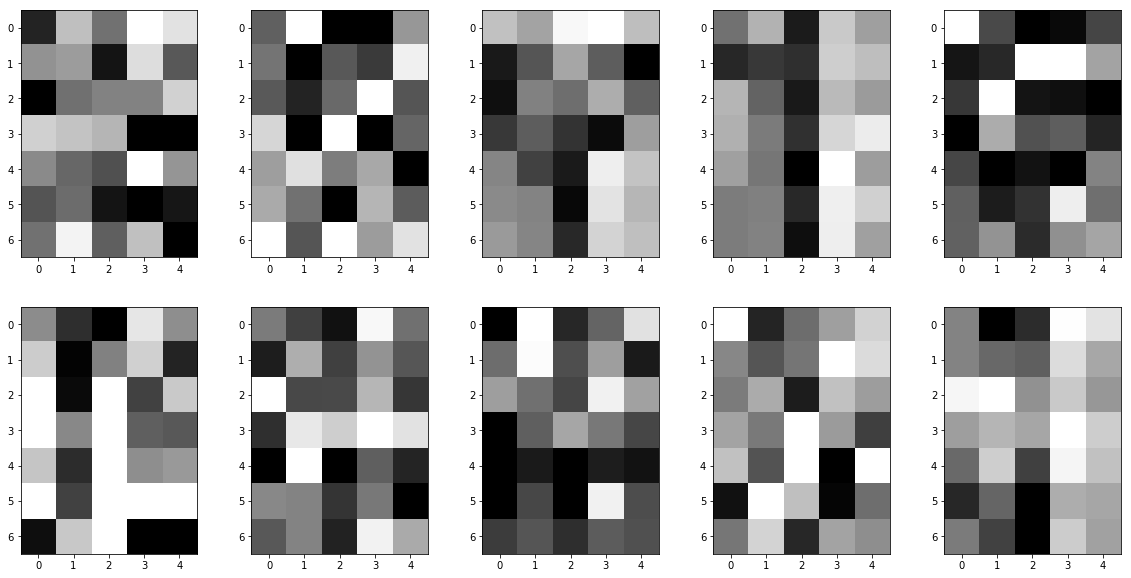

In [12]:
n=10
plt.figure(figsize=(20,10))
for i in range(n):
    # display original
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()


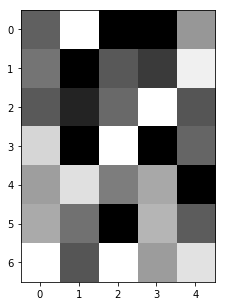

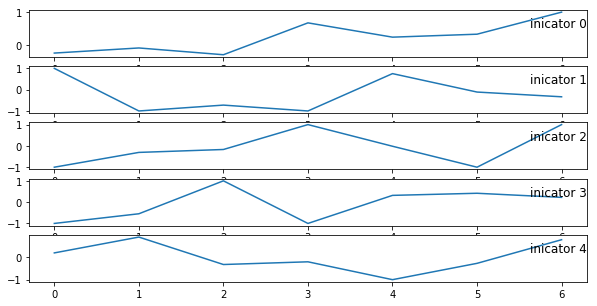

target for this example is  [3]
([0]-strong down  [1]-waek down  [2]-neutral  [3]-week up [4]-strong up ) 


In [13]:

plt.figure(figsize=(5,5))
plt.imshow(X_train[1])
#plt.gray()
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
plt.show()


from matplotlib import pyplot
groups = [0, 1, 2, 3, 4]
values=X_train[1]
i=1
plt.figure(figsize=(10,5))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:,group])
	pyplot.title("inicator "+str(group), y=0.5, loc='right')
	i += 1
pyplot.show()

print("target for this example is ", y_train[1])
print("([0]-strong down  [1]-waek down  [2]-neutral  [3]-week up [4]-strong up ) ")



Imports for the auto encoder 2D

In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.layers.pooling import AveragePooling2D
from numpy import vstack, hstack
from keras.legacy.layers import merge
from keras.layers.core import Lambda

K.set_image_dim_ordering("th")



Using TensorFlow backend.


In [47]:
input_img = Input(shape=(1, 7, 5))  
x = Conv2D(5, (3, 3), activation='relu', padding='same')(input_img)
x = AveragePooling2D(pool_size=(3, 2), strides=(1, 1), padding='same')(x)
encoded = Conv2D(2, (3, 3), activation='relu', padding='same')(x)

lstmsVec=[]
for x in range(0,2):
    filterImg=Lambda(lambda element : element[:,x,:,:])(encoded)
    lstmsVec.append(filterImg)
merged = merge(lstmsVec, mode='concat',concat_axis=2)

lstm=Bidirectional(LSTM(20),merge_mode='concat')(merged)
#lstm=Bidirectional(LSTM(50),merge_mode='concat')(merged)#(inputNet)
classificationLayer=Dense(classes,activation='softmax')(lstm)#(lstm)



x = Conv2D(2, (3, 3), activation='relu', padding='same')(encoded)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((1, 1))(x)
x = Conv2D(5, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

encoder = Model(input_img, encoded)

encoderHstack= Model(input_img,merged)

encoderHstackLSTMClass= Model(input_img,classificationLayer)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()


/home/rjpg/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rjpg/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 1, 7, 5)           0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 5, 7, 5)           50        
_________________________________________________________________
average_pooling2d_13 (Averag (None, 5, 7, 5)           0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 2, 7, 5)           92        
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 2, 7, 5)           38        
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 2, 7, 5)           0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 5, 7, 5)           95        
__________

## Autoencoder architecture 

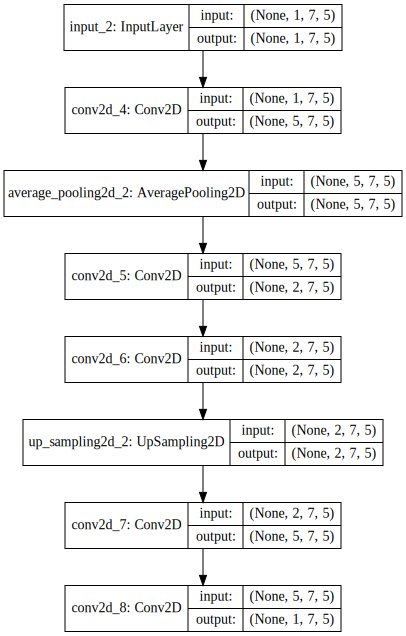

In [27]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(autoencoder,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

## Encoder with horizontal stacked filters 

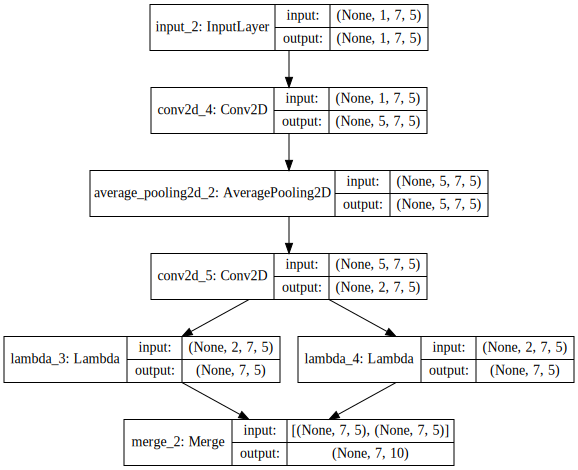

In [28]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(encoderHstack,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

## Encoder -> HSTACK -> LSTM -> Classification 


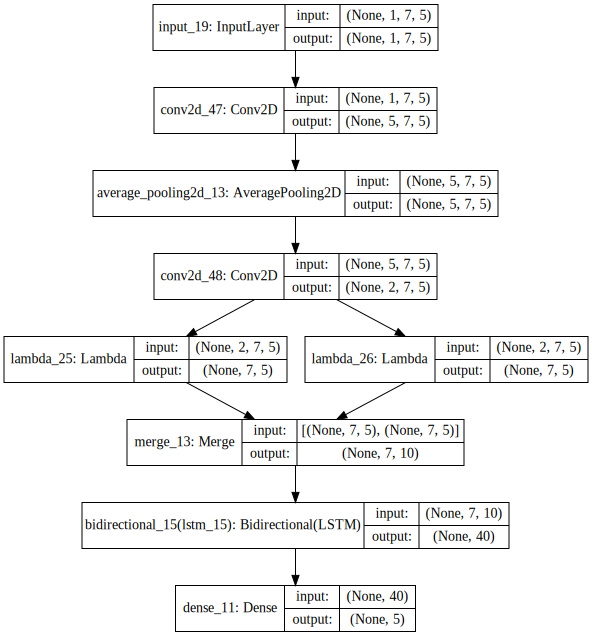

In [48]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(encoderHstackLSTMClass,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

In [23]:
#X_train = X_train[:, np.newaxis, :, :]
print (X_train.shape)

VALIDATION_SPLIT=0.2
X_train_new = X_train[:, np.newaxis, :, :]

autoencoder.fit(X_train_new, X_train_new,
                epochs=20,
                batch_size=128,
                #shuffle=True,
                verbose=2,
                validation_split=VALIDATION_SPLIT,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])


(19456, 7, 5)
Train on 15564 samples, validate on 3892 samples
Epoch 1/20
3s - loss: -2.5177e+00 - val_loss: -2.8579e+00
Epoch 2/20
3s - loss: -3.1179e+00 - val_loss: -3.2243e+00
Epoch 3/20
3s - loss: -3.3563e+00 - val_loss: -3.3672e+00
Epoch 4/20
3s - loss: -3.4794e+00 - val_loss: -3.4678e+00
Epoch 5/20
3s - loss: -3.5546e+00 - val_loss: -3.5218e+00
Epoch 6/20
3s - loss: -3.5946e+00 - val_loss: -3.5521e+00
Epoch 7/20
3s - loss: -3.6187e+00 - val_loss: -3.5707e+00
Epoch 8/20
3s - loss: -3.6356e+00 - val_loss: -3.5867e+00
Epoch 9/20
3s - loss: -3.6485e+00 - val_loss: -3.5977e+00
Epoch 10/20
5s - loss: -3.6589e+00 - val_loss: -3.6075e+00
Epoch 11/20
3s - loss: -3.6675e+00 - val_loss: -3.6159e+00
Epoch 12/20
3s - loss: -3.6749e+00 - val_loss: -3.6221e+00
Epoch 13/20
3s - loss: -3.6814e+00 - val_loss: -3.6290e+00
Epoch 14/20
4s - loss: -3.6874e+00 - val_loss: -3.6347e+00
Epoch 15/20
4s - loss: -3.6927e+00 - val_loss: -3.6397e+00
Epoch 16/20
5s - loss: -3.6975e+00 - val_loss: -3.6442e+00
Ep

Again original image or time series from example [1]

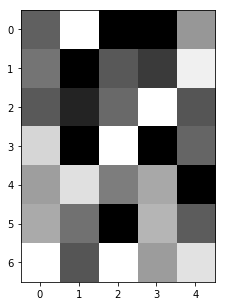

In [25]:
plt.figure(figsize=(5,5))
print 
plt.imshow(X_train_new[1,0,:,:])
#plt.gray()
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
plt.show()

How example[1] is transformed by the encoders :

In [24]:
encoded_imgsHstak = encoderHstack.predict(X_train_new)


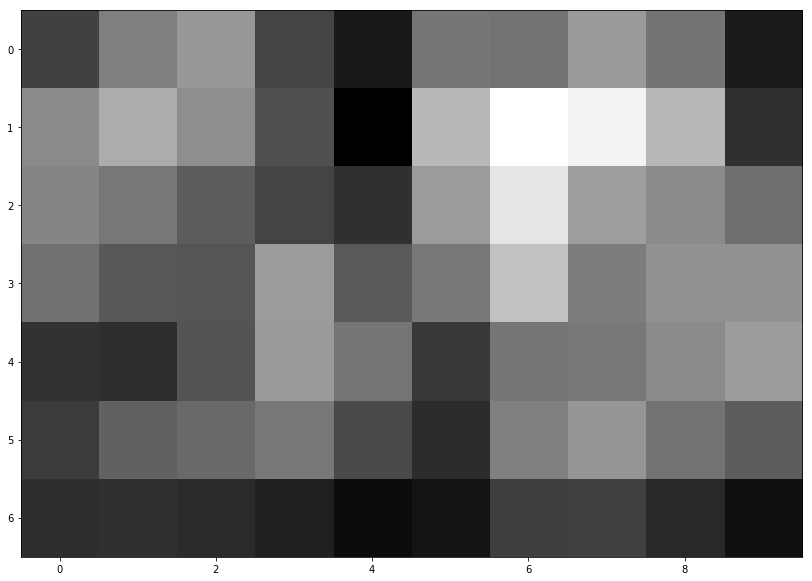

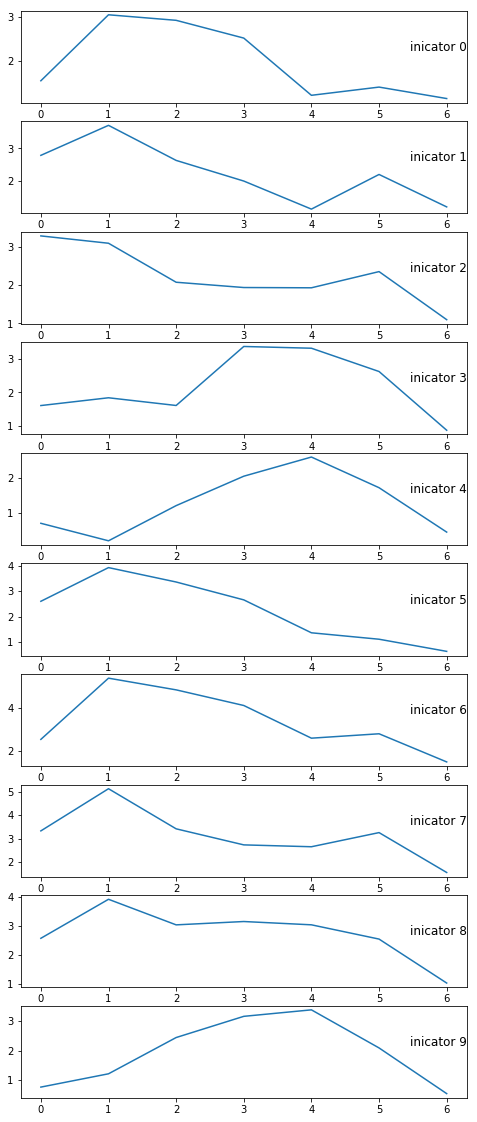

In [26]:




image = encoded_imgsHstak[1,:,:]

plt.figure(figsize=(14, 25))
plt.imshow(image)
#plt.gray()
plt.show()

from matplotlib import pyplot

values=image
i=1
plt.figure(figsize=(8,20))
for group in range(0,10):
	pyplot.subplot(10, 1, i)
	pyplot.plot(values[:,group])
	pyplot.title("inicator "+str(group), y=0.5, loc='right')
	i += 1
pyplot.show()



## Now lets build the LSTM classifier in front of the encoded Horizontal Stacked filters 


In [58]:
for layer in encoderHstack.layers : layer.trainable = False

NB_CLASSES=5
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)    
    
    
OPTIMIZER = Adam()
encoderHstackLSTMClass.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])
history = encoderHstackLSTMClass.fit(X_train_new, Y_train,
                epochs=20,       #Only 20 to test 
                batch_size=128,
                shuffle=True,
                verbose=2,
                validation_split=VALIDATION_SPLIT)#,
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])



Train on 15564 samples, validate on 3892 samples
Epoch 1/20
5s - loss: 1.5825 - acc: 0.2651 - val_loss: 1.5911 - val_acc: 0.2577
Epoch 2/20
3s - loss: 1.5832 - acc: 0.2629 - val_loss: 1.5874 - val_acc: 0.2590
Epoch 3/20
5s - loss: 1.5814 - acc: 0.2675 - val_loss: 1.5868 - val_acc: 0.2564
Epoch 4/20
6s - loss: 1.5803 - acc: 0.2646 - val_loss: 1.5869 - val_acc: 0.2585
Epoch 5/20
6s - loss: 1.5806 - acc: 0.2677 - val_loss: 1.5881 - val_acc: 0.2634
Epoch 6/20
7s - loss: 1.5797 - acc: 0.2673 - val_loss: 1.5856 - val_acc: 0.2641
Epoch 7/20
5s - loss: 1.5791 - acc: 0.2676 - val_loss: 1.5853 - val_acc: 0.2515
Epoch 8/20
6s - loss: 1.5780 - acc: 0.2702 - val_loss: 1.5858 - val_acc: 0.2595
Epoch 9/20
5s - loss: 1.5773 - acc: 0.2693 - val_loss: 1.5848 - val_acc: 0.2626
Epoch 10/20
6s - loss: 1.5763 - acc: 0.2693 - val_loss: 1.5860 - val_acc: 0.2680
Epoch 11/20
5s - loss: 1.5763 - acc: 0.2713 - val_loss: 1.5839 - val_acc: 0.2670
Epoch 12/20
5s - loss: 1.5756 - acc: 0.2742 - val_loss: 1.5855 - val_

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


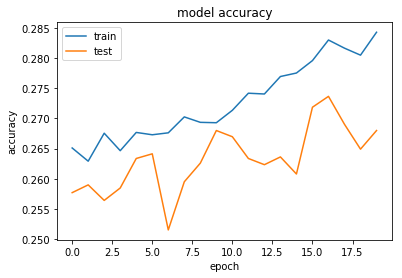

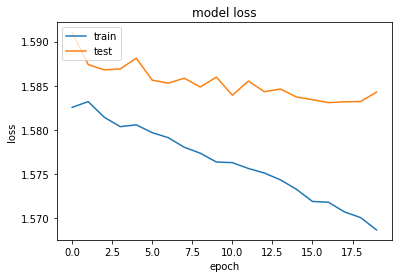

In [59]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()